This tutorial demonstrates how to generate a Relion Dataset using `cryojax`. This tutorial builds upon tools already shown in other tutorials, so we might skip over some details.

In [1]:
%load_ext autoreload
%autoreload 2

First we will do all the imports required to run the tutorial

In [2]:
# Jax and Equinox imports
from functools import partial

import equinox as eqx
import equinox.internal as eqxi
import jax
import jax.numpy as jnp
from jaxtyping import PRNGKeyArray

In [3]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [4]:
# CryoJAX imports

import cryojax.simulator as cxs
from cryojax.data import generate_starfile, RelionDataset, RelionParticleStack
from cryojax.image import operators as op
from cryojax.io import read_atoms_from_pdb
from cryojax.rotations import SO3

# Generating a starfile

We have split this tutorial in two parts. In the first part we will generate a starfile, but we will not generate any particles. In the second part we will show how to generate particles from a starfile, and how to save such particles to the respective MRC Files.

We have decided to keep this two steps separate for a simple reason, flexibility. We want to make it possible for every user to design their own image formation pipeline. In some of our other tutorials we have showed how to generate noiseless image, images with solvent noise, or images with noise coming from a distribution. You can easily adapt this tutorial to those cases, or any other pipeline you build.

Now we will start by generating a starfile. To do this, we will first create a cryojax RelionParticleStack.

In this function we vmap over `jax` random keys. You can adapt this function to your needs, such as adapting the range of the distributions for the random parameters, or changing wheter a parameter is random or not.

In [5]:
@partial(eqx.filter_vmap, in_axes=(0, None), out_axes=eqxi.if_mapped(axis=0))
def make_relion_dataset(
    key: PRNGKeyArray, instrument_config: cxs.InstrumentConfig
) -> RelionParticleStack:
    # Generate random parameters

    # Pose
    # ... instantiate rotations
    rotation = SO3.sample_uniform(key)
    key, subkey = jax.random.split(key)  # split the key to use for the next random number

    # ... now in-plane translation
    ny, nx = instrument_config.shape
    in_plane_offset_in_angstroms = (
        jax.random.uniform(subkey, (2,), minval=-0.2, maxval=0.2)
        * jnp.asarray((nx, ny))
        * instrument_config.pixel_size
    )
    key, subkey = jax.random.split(key)  # do this everytime you use a key!!

    # ... convert 2D in-plane translation to 3D, setting the out-of-plane translation to
    # zero
    offset_in_angstroms = jnp.pad(in_plane_offset_in_angstroms, ((0, 1),))
    # ... build the pose
    pose = cxs.EulerAnglePose.from_rotation_and_translation(rotation, offset_in_angstroms)

    # CTF Parameters
    # ... defocus
    defocus_in_angstroms = jax.random.uniform(subkey, (), minval=1000, maxval=1500)
    key, subkey = jax.random.split(key)

    astigmatism_in_angstroms = jax.random.uniform(subkey, (), minval=0, maxval=100)
    key, subkey = jax.random.split(key)

    astigmatism_angle = jax.random.uniform(subkey, (), minval=0, maxval=jnp.pi)
    key, subkey = jax.random.split(key)

    # now generate your non-random values
    spherical_aberration_in_mm = 2.7
    amplitude_contrast_ratio = 0.1
    phase_shift = 0.0
    b_factor = 170.0
    ctf_scale_factor = 1.0

    # ... build the CTF
    transfer_theory = cxs.ContrastTransferTheory(
        ctf=cxs.ContrastTransferFunction(
            defocus_in_angstroms=defocus_in_angstroms,
            astigmatism_in_angstroms=astigmatism_in_angstroms,
            astigmatism_angle=astigmatism_angle,
            voltage_in_kilovolts=instrument_config.voltage_in_kilovolts,
            spherical_aberration_in_mm=spherical_aberration_in_mm,
            amplitude_contrast_ratio=amplitude_contrast_ratio,
            phase_shift=phase_shift,
        ),
        envelope=op.FourierGaussian(b_factor=b_factor, amplitude=ctf_scale_factor),
    )

    relion_particle_stack = RelionParticleStack(
        instrument_config=instrument_config,
        pose=pose,
        transfer_theory=transfer_theory,
    )
    return relion_particle_stack

!!! info "What's with the `out_axes=eqxi.if_mapped(axis=0)`?"
    
    When we create a pytree with `eqx.filter_vmap` (or `jax.vmap`), `out_axes` should have the same structure as the output pytree. If `out_axes` is set to `None` at a particular leaf, this
    says that we do not want to broadcast that leaf (of course, this only works for unmapped leaves). By default `jax.vmap` sets `out_axes=0`, so all unmapped leaves get broadcasted. `equinox` allows us to pass `out_axes=eqxi.if_mapped(axes=0)`, which specifies *not* to broadcast pytree leaves unless the leaves are directly mapped.

In [6]:
# Generate instrument config
instrument_config = cxs.InstrumentConfig(
    shape=(128, 128),
    pixel_size=1.5,
    voltage_in_kilovolts=300.0,
    pad_scale=1.0,  # no padding
)

# Generate RNG keys
number_of_images = 100
keys = jax.random.split(jax.random.PRNGKey(0), number_of_images)

# ... instantiate the RelionParticleStack
relion_particle_stack = make_relion_dataset(keys, instrument_config)

In [7]:
relion_particle_stack

RelionParticleStack(
  instrument_config=InstrumentConfig(
    shape=(128, 128),
    pixel_size=f32[],
    voltage_in_kilovolts=f32[],
    electrons_per_angstrom_squared=f32[],
    padded_shape=(128, 128),
    pad_mode='constant'
  ),
  pose=EulerAnglePose(
    offset_x_in_angstroms=f32[100],
    offset_y_in_angstroms=f32[100],
    offset_z_in_angstroms=0.0,
    view_phi=f32[100],
    view_theta=f32[100],
    view_psi=f32[100]
  ),
  transfer_theory=ContrastTransferTheory(
    ctf=ContrastTransferFunction(
      defocus_in_angstroms=f32[100],
      astigmatism_in_angstroms=f32[100],
      astigmatism_angle=f32[100],
      voltage_in_kilovolts=f32[],
      spherical_aberration_in_mm=f32[],
      amplitude_contrast_ratio=f32[],
      phase_shift=f32[]
    ),
    envelope=FourierGaussian(amplitude=f32[], b_factor=f32[])
  ),
  image_stack=None
)

To see the values of any particular parameter, you can do

In [8]:
eqx.tree_pprint(relion_particle_stack.pose, short_arrays=False)

EulerAnglePose(
  offset_x_in_angstroms=Array([ 27.838387  ,  -5.8113923 ,  29.99556   , -29.857536  ,
        31.73444   ,   8.509122  ,  12.731892  ,  14.672131  ,
       -11.701071  , -26.708862  ,  36.032738  ,   7.5504184 ,
        17.518442  , -17.353676  , -30.24007   , -14.270517  ,
        21.491465  , -38.351585  ,   7.7037783 ,   1.1563478 ,
         3.1571138 ,  14.415272  ,  20.146309  ,  37.02233   ,
       -30.147831  ,  27.245197  ,  22.148996  , -12.468998  ,
       -11.253296  ,  22.520609  ,  20.226269  ,  36.7795    ,
        16.340965  ,  29.737328  , -21.717564  ,  -2.958023  ,
        15.68454   ,   6.8867245 , -10.9807625 ,  -3.7431154 ,
        33.33642   ,  -9.772705  , -26.341423  , -19.160229  ,
        10.792429  ,   0.70355535, -37.73714   , -26.256392  ,
        34.984974  ,  16.63483   ,  15.190998  ,  14.724051  ,
       -34.482224  ,  26.213936  ,  -6.7653446 ,  23.609657  ,
       -35.55948   ,  13.715698  ,   8.83646   , -15.006939  ,
        30.2144

Lastly, we can easily generate the starfile from the built-in `cryojax.data.generate_starfile` function.

The `mrc_batch_size` parameter let's you specify how many particles you want per mrcfile.

In this case we will place 50 images per mrcfile, giving us two mrcfiles.

In [9]:
# ... generate the starfile
generate_starfile(relion_particle_stack, "relion_dataset.star", mrc_batch_size=50)

# Generating particles from starfile

In this section we will read the generated starfile, use it to build an imaging pipeline, and then use that image pipeline to generate mrcfiles.

In [10]:
# First load the starfile

path_to_mrc_files = "./relion_dataset_particles"
dataset = RelionDataset(
    path_to_starfile="./relion_dataset.star",  # starfile we created
    path_to_relion_project=path_to_mrc_files,
    get_image_stack=False,  # not loading particles as they don't exist yet
    get_envelope_function=True,
)

!!! info "For more information on the RelionDataset object, check our `Read a particle stack` tutorial."

Now let's define the structure we will use to generate images. In this case, we show how to load a pdb and then turn it into a voxel grid. We all need to define how we will integrate our potential.

In [11]:
filename = "./data/groel_chainA.pdb"
atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    filename, assemble=False, get_b_factors=True
)
atomic_potential = cxs.PengAtomicPotential(atom_positions, atom_identities, b_factors)

# get values from the "optics" datablock in the starfile
box_size = dataset[0].instrument_config.shape[0]
voxel_size = dataset[0].instrument_config.pixel_size

real_voxel_grid = atomic_potential.as_real_voxel_grid(
    shape=(box_size, box_size, box_size), voxel_size=voxel_size
)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)

potential_integrator = cxs.FourierSliceExtraction(interpolation_order=1)

Now we will create a template for our imaging pipeline. The pose and transfer theory will be generated using default values, as the values will be updated from the starfile we generated in the previous step.

In [12]:
pose = cxs.EulerAnglePose()

transfer_theory = cxs.ContrastTransferTheory(ctf=cxs.ContrastTransferFunction())

structural_ensemble = cxs.SingleStructureEnsemble(potential, pose)

scattering_theory = cxs.WeakPhaseScatteringTheory(
    structural_ensemble, potential_integrator, transfer_theory
)

strength = 0.05 * real_voxel_grid.sum(axis=0).max() * voxel_size
solvent = cxs.GaussianIce(
    variance_function=op.Lorenzian(
        amplitude=strength**2, length_scale=2.0 * potential.voxel_size
    )
)

imaging_pipeline = cxs.ContrastImagingPipeline(instrument_config, scattering_theory)

!!! info "For more information on imaging pipelines check the `Simulate an image` tutorial."

Checking how an image generated from the imaging pipeline looks

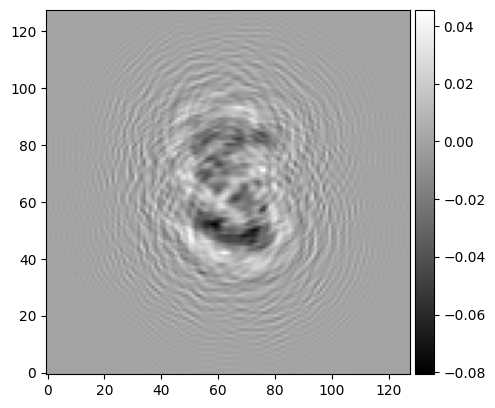

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im1 = plot_image(
    imaging_pipeline.render(),
    fig,
    ax,
)

Define a noise distribution

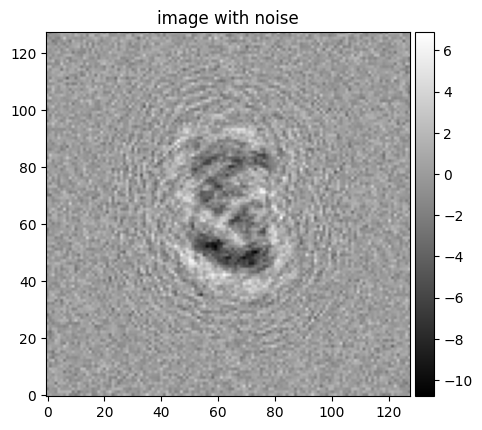

In [14]:
from cryojax.inference import distributions as dist


distribution = dist.IndependentGaussianFourierModes(
    imaging_pipeline,
    signal_scale_factor=jnp.sqrt(instrument_config.n_pixels),
    variance_function=op.Constant(1.0),
)

key = jax.random.PRNGKey(seed=0)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))
im1 = plot_image(
    distribution.sample(key),
    fig,
    ax1,
    label="image with noise",
)

Now we will generate the particles. This is the trickiest bit of the tutorial, make sure to check the comments in the code.

First we will define a function that generates images from our previously defined distribution. Notice that this function has three arguments: `dist_vmap`, `dist_novmap`, and `key`. As the name suggest, `dist_vmap` is an equinox filtered distribution object, which contains the leaves that we will vmap over (the ones we defined before with `vmap_filter`). Similarly, the `dist_novmap` contains the leaves we will not vmap over. We also need a different `key` per image, otherwise images would have the same noise, so we also vmap over that argument.

    We perform this filtering inside our code, you only need to worry about defining your function properly.

You could easily change this to a plain `imaging_pipeline` object. In that case you would not need the key, and you would to slightly change the definition of `vmap_filter`. Our `Simulate a batch of images` tutorial shows how to do so. There is also a short example of how to do it at the end of this tutorial.

In [17]:
@eqx.filter_jit
@eqx.filter_vmap(in_axes=(0, 0, None))
def compute_noisy_image_stack(
    key: PRNGKeyArray,
    dist_vmap: dist.AbstractDistribution,
    dist_novmap: dist.AbstractDistribution,
):
    """Simulate an image with noise from a `imaging_pipeline`."""

    # Combine two previously split PyTrees
    distribution = eqx.combine(dist_vmap, dist_novmap)

    return distribution.sample(key)

In [18]:
from cryojax.data import write_simulated_image_stack_from_starfile


write_simulated_image_stack_from_starfile(
    dataset,
    compute_noisy_image_stack,
    distribution,
    seed=0,
    overwrite=True,
)

Now we can load our Dataset with `get_image_stack=True` as the particles do exist now

In [19]:
dataset = RelionDataset(
    path_to_starfile="relion_dataset.star",
    path_to_relion_project="relion_dataset_particles/",
    get_image_stack=True,
)

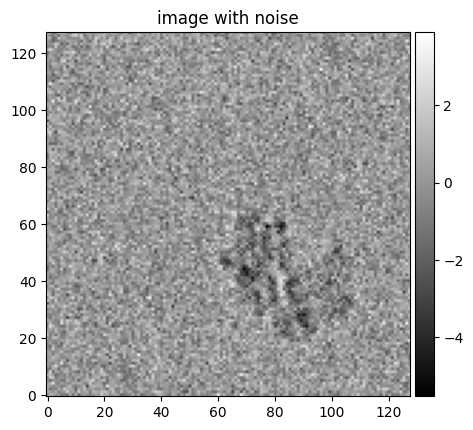

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

im1 = plot_image(
    dataset[0].image_stack,
    fig,
    ax,
    label="image with noise",
)

## What if I don't want noise?

Here is an example of how you could achieve the same result with a regular `imaging_pipeline`

```python
@eqx.filter_jit
@eqx.filter_vmap(in_axes=(0, None))
def compute_image_stack(
    img_pipeline_vmap: cxs.AbstractImagingPipeline,
    img_pipeline_novmap: cxs.AbstractImagingPipeline
):
    """Simulate an image with noise from a `imaging_pipeline`."""

    # Combine two previously split PyTrees
    img_pipeline = eqx.combine(img_pipeline_vmap, img_pipeline_novmap)

    return img_pipeline.render()

write_simulated_image_stack_from_starfile(
    dataset,
    compute_image_stack,
    imaging_pipeline, # the imagine pipeline we created before!
    seed=None,
    overwrite=True,
)
```